# Deep Image Classification

In this set of lecture notes, we'll work through an applied case study of deep learning for image classification. Like [our last adventure with an image classification task](51-vectorization.ipynb), we'll focus on sign-language classification using convolutional kernels. This time, however, we won't take the kernels as given. Instead, we'll attempt to optimize the kernels as part of the learning process.

Along the way, we'll also study some of the practicalities of working with larger models in torch, including model inspection, GPU acceleration, and data set management.

In [109]:
import torch
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
from torch.nn import Conv2d, MaxPool2d, Parameter
from torch.nn.functional import relu
from sklearn.metrics import confusion_matrix

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {device}.")


Running on cuda.


In [110]:
train_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/sign-language-mnist/sign_mnist_train.csv"
test_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/sign-language-mnist/sign_mnist_test.csv"

df_train = pd.read_csv(train_url)
df_val   = pd.read_csv(test_url)

def prep_data(df):
    n, p = df.shape[0], df.shape[1] - 1
    y = torch.tensor(df["label"].values)
    X = df.drop(["label"], axis = 1)
    X = torch.tensor(X.values)
    X = torch.reshape(X, (n, 1, 28, 28))
    X = X / 255

    return X.to(device), y.to(device)

X_train, y_train = prep_data(df_train)
X_val, y_val     = prep_data(df_val)

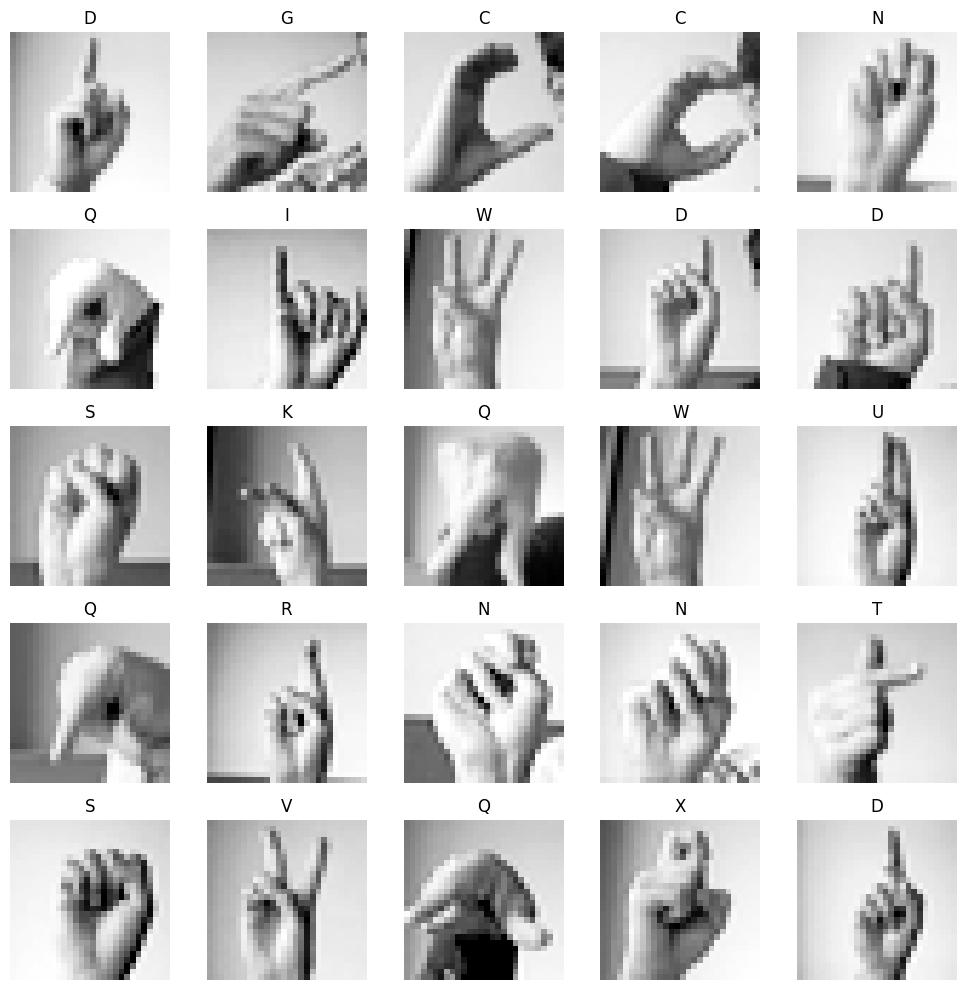

In [111]:
ALPHABET = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

def show_images(X, y, rows, cols, channel = 0):

    fig, axarr = plt.subplots(rows, cols, figsize = (2*cols, 2*rows))
    for i, ax in enumerate(axarr.ravel()):
        ax.imshow(X[i, channel].detach().cpu(), cmap = "Greys_r")
        ax.set(title = f"{ALPHABET[y[i]]}")
        ax.axis("off")
    plt.tight_layout()

show_images(X_train, y_train, 5, 5)

In [112]:
data_loader_train = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train, y_train),
    batch_size = 32,
    shuffle = True
)

data_loader_val = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_val, y_val),
    batch_size = 32,
    shuffle = True
)

### A Note On Multiclass Classification

We're actually now making our first formal study of a multiclass classification problem, in which we are trying to distinguish data observations into more than two possible categories. Whereas before we didn't really comment on the specific structure of this problem, here we need to build up a model from scratch and therefore need to understand how it works!

Typically, classification models return a score *for each class*. Then, the class with the highest score is usually considered to be the model's prediction. This means that the score function should actually return a *vector* of scores for each data observation.

In order to make this happen for a single-layer model, we move from a matrix-vector multiplication $\mathbf{X}\mathbf{w}$ to a matrix-matrix multiplication $\mathbf{X}\mathbf{W}$, where $\mathbf{W} \in \mathbb{R}^{p \times r}$ has number of rows equal to the number of features and number of columns equal to the number of classes.

More generally, we can define our model in any way we like, as long as it returns a vector of scores for each data observation.

It is also necessary to modify the loss function for classification models. Instead of the binary cross entropy, we need to define a multiclass generalization. The most common choice of per-observation loss function between a vector of class scores $\mathbf{s} \in \mathbb{R}^r$ and the true label $y_i$ is

$$
\ell(\mathbf{s}_i, y_i) = \sum_{j = 1}^r \mathbb{1}[y_i = j]\log\left(\frac{e^{s_{ij}}}{\sum_{k = 1}^r e^{s_{ik}}}\right)
$$

The function

$$
\mathrm{softmax}(\mathbf{s}) = \left(\begin{matrix}
    \frac{e^{s_1}}{\sum_{j = 1}^r e^{s_j}} \\
    \frac{e^{s_2}}{\sum_{j = 1}^r e^{s_j}} \\
    \vdots
    \frac{e^{s_r}}{\sum_{j = 1}^r e^{s_j}}
    \end{matrix}\right)
$$

is a generalization of the logistic sigmoid function to the multiclass setting. It is called the softmax function because it has a tendency to accentuate the largest value in the vector $\mathbf{s}$. With this notation, we can write the cross-entropy loss as

$$
\ell(\mathbf{s}_i, y_i) = \sum_{j = 1}^r \mathbb{1}[y_i = j]\log \mathrm{softmax}(\mathbf{s}_i)_j\;.
$$

Summing the per-observation loss over all data points gives the empirical risk to be minimized.

Let's implement a linear model with the multiclass cross entropy. This first model is equivalent to multiclass logistic regression.


In [113]:
import torch.nn as nn
import torch.nn.functional as F

#---
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(28*28, 26)

    # this is the customary name for the method that computes the scores
    # the loss is usually computed outside the model class during the training loop
    def forward(self, x):

        x = torch.flatten(x, 1)
        x = self.linear(x)
        return x

    def predict(self, x):

        scores = self.forward(x)
        return torch.argmax(scores, dim = 1)

model = LinearModel().to(device)
#---

The `forward` method computes a matrix of scores. Each row of this matrix gives the scores for a single observation:

In [114]:
scores = model(X_train)
scores

tensor([[-0.9430, -0.1960, -0.1161,  ...,  0.1393,  0.2590, -0.1865],
        [-0.9258, -0.2945, -0.0368,  ...,  0.0859,  0.2588, -0.1031],
        [-0.9101, -0.2176,  0.0202,  ...,  0.2697,  0.3611, -0.0943],
        ...,
        [-0.9361, -0.3241, -0.2227,  ...,  0.2526,  0.1775, -0.1715],
        [-1.2309, -0.4538,  0.0266,  ...,  0.2588,  0.3381, -0.1046],
        [-0.8994, -0.1279, -0.1593,  ...,  0.1751,  0.3480, -0.0484]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

The `predict` method just computes these scores and returns the column index of the largest score in each column.

In [115]:
torch.argmax(scores, dim = 1) # indices of predicted letters

tensor([11, 10, 10,  ...,  3, 10,  3], device='cuda:0')

It's very useful to get in the habit of *inspecting* your models in order to understand how they are organized and how many parameters need to be trained. One convenient way to do this is with the `summary` function provided by the `torchsummary` package. This function requires that we input the dimensions of a single observation:

In [116]:
from torchsummary import summary
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 26]          20,410
Total params: 20,410
Trainable params: 20,410
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.08
Estimated Total Size (MB): 0.08
----------------------------------------------------------------


Even this simple multiclass logistic model has over 20,000 parameters to train!

Let's implement a simple training loop. This loop will include provisions to train the model while also updating us on the performance of the model as measured by the accuracy on the validation set.

In [117]:
import torch.optim as optim

def evaluate(model):
    total = 0
    total_correct = 0
    for X, y in data_loader_val:
        X, y = X.to(device), y.to(device)

        scores = model.forward(X)
        y_pred =  torch.argmax(scores, dim = 1)
        total += X.size(0)
        total_correct += (y_pred == y).sum().item()

    print(f"validation accuracy = {total_correct / total:.3f}")

def train(model, k_epochs = 1, print_every = 2000, evaluate_after_epoch = True, **opt_kwargs):
    # loss function is cross-entropy (multiclass logistic)
    loss_fn = nn.CrossEntropyLoss()

    # optimizer is SGD with momentum
    optimizer = optim.SGD(model.parameters(), **opt_kwargs)

    for epoch in range(k_epochs):
        for i, data in enumerate(data_loader_train):
            X, y = data
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()

            if (i + 1) % print_every == 0:
                print(f"Epoch {epoch}, batch {i:>3}, loss on batch: {loss.item():.3f}")

        if evaluate_after_epoch:
            print(f"Epoch {epoch}: ", end = "")
            evaluate(model)

In [118]:
train(model, k_epochs = 10, lr = 0.001, evaluate_after_epoch = True)

Epoch 0: validation accuracy = 0.134
Epoch 1: validation accuracy = 0.179
Epoch 2: validation accuracy = 0.290
Epoch 3: validation accuracy = 0.321
Epoch 4: validation accuracy = 0.319
Epoch 5: validation accuracy = 0.373
Epoch 6: validation accuracy = 0.389
Epoch 7: validation accuracy = 0.405
Epoch 8: validation accuracy = 0.431
Epoch 9: validation accuracy = 0.432


Once we have trained the model, we can extract predictions and compare them to true targets. Here's our accuracy after training on the validation set.

## Convolutional Models

Our favorite logistic regression is a great algorithm, but there is lots of room to improve! Last time we studied this data set, we used convolutional kernels to extract more helpful features from the data before finally plugging those features into a logistic regression model. We sandwiched those convolutional layers between pooling and ReLU activation layers. This time, instead of treating these kernels as given, we are going to learn them as part of the optimization routine.

*Starting from this point in the notes, it is strongly recommended to run this code with a GPU available, such as in Google Colab*.

In [119]:
import torch.nn as nn
from  torch.nn.functional import relu

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        # first convolutional layer
        # 1 color channel, 100 different kernels, kernel size = 5x5
        self.conv1 = nn.Conv2d(1, 100, 5)

        # shrinks the image by taking the largest pixel in each 2x2 square
        self.pool = nn.MaxPool2d(2, 2)

        # 100 channels (from previous convolutional layer), 50 new kernels, kernel size = 3x3
        self.conv2 = nn.Conv2d(100, 50, 3)

        # EVEN MOAR CONVOLUTION: 50 channels, 50 new kernels, kernel size 3x3
        self.conv3 = nn.Conv2d(50, 50, 3)

        # EVEN MOAR CONVOLUTION: 50 channels, 50 new kernels, kernel size 3x3
        self.conv4 = nn.Conv2d(50, 50, 3)

        # a linear layer on top of the kernels

        self.linear1 = nn.Linear(450, 512)
        self.linear2 = nn.Linear(512, 128)
        self.linear3 = nn.Linear(128, len(ALPHABET))


    def forward(self, x):

        # these layers use the spatial structure of the image
        # so we don't flatten yet
        x = relu(self.conv1(x))
        x = relu(self.conv2(x))
        x = self.pool(x)

        x = relu(self.conv3(x))
        x = relu(self.conv4(x))
        x = self.pool(x)

        x = torch.flatten(x, 1)
        x = relu(self.linear1(x))
        x = relu(self.linear2(x))
        x = relu(self.linear3(x))

        return x

model = ConvNet().to(device)

What does this model look like?

In [120]:
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 100, 24, 24]           2,600
            Conv2d-2           [-1, 50, 22, 22]          45,050
         MaxPool2d-3           [-1, 50, 11, 11]               0
            Conv2d-4             [-1, 50, 9, 9]          22,550
            Conv2d-5             [-1, 50, 7, 7]          22,550
         MaxPool2d-6             [-1, 50, 3, 3]               0
            Linear-7                  [-1, 512]         230,912
            Linear-8                  [-1, 128]          65,664
            Linear-9                   [-1, 26]           3,354
Total params: 392,680
Trainable params: 392,680
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.73
Params size (MB): 1.50
Estimated Total Size (MB): 2.23
-------------------------------------------

This model has more parameters than the logistic regression model. However, the convolutional layers also give it the potential to usefully leverage the spatial structure of the data.

In [121]:
train(model, k_epochs = 30,  lr = 0.01, evaluate_after_epoch = True, momentum = 0.9)

Epoch 0: validation accuracy = 0.212
Epoch 1: validation accuracy = 0.718
Epoch 2: validation accuracy = 0.816
Epoch 3: validation accuracy = 0.852
Epoch 4: validation accuracy = 0.851
Epoch 5: validation accuracy = 0.852
Epoch 6: validation accuracy = 0.853
Epoch 7: validation accuracy = 0.852
Epoch 8: validation accuracy = 0.852
Epoch 9: validation accuracy = 0.852
Epoch 10: validation accuracy = 0.852
Epoch 11: validation accuracy = 0.851
Epoch 12: validation accuracy = 0.851
Epoch 13: validation accuracy = 0.851
Epoch 14: validation accuracy = 0.851
Epoch 15: validation accuracy = 0.851
Epoch 16: validation accuracy = 0.851
Epoch 17: validation accuracy = 0.851
Epoch 18: validation accuracy = 0.849
Epoch 19: validation accuracy = 0.852
Epoch 20: validation accuracy = 0.852
Epoch 21: validation accuracy = 0.852
Epoch 22: validation accuracy = 0.852
Epoch 23: validation accuracy = 0.852
Epoch 24: validation accuracy = 0.852
Epoch 25: validation accuracy = 0.852
Epoch 26: validation a